# **AUTOENCODERS**

In [ ]:
# Standard Packages
import os
import sys
import time
import pickle
import numpy as np
import itertools

# Deep Learning
import torch

# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import BoundaryNorm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **AutoEncoders for Anomaly Detection**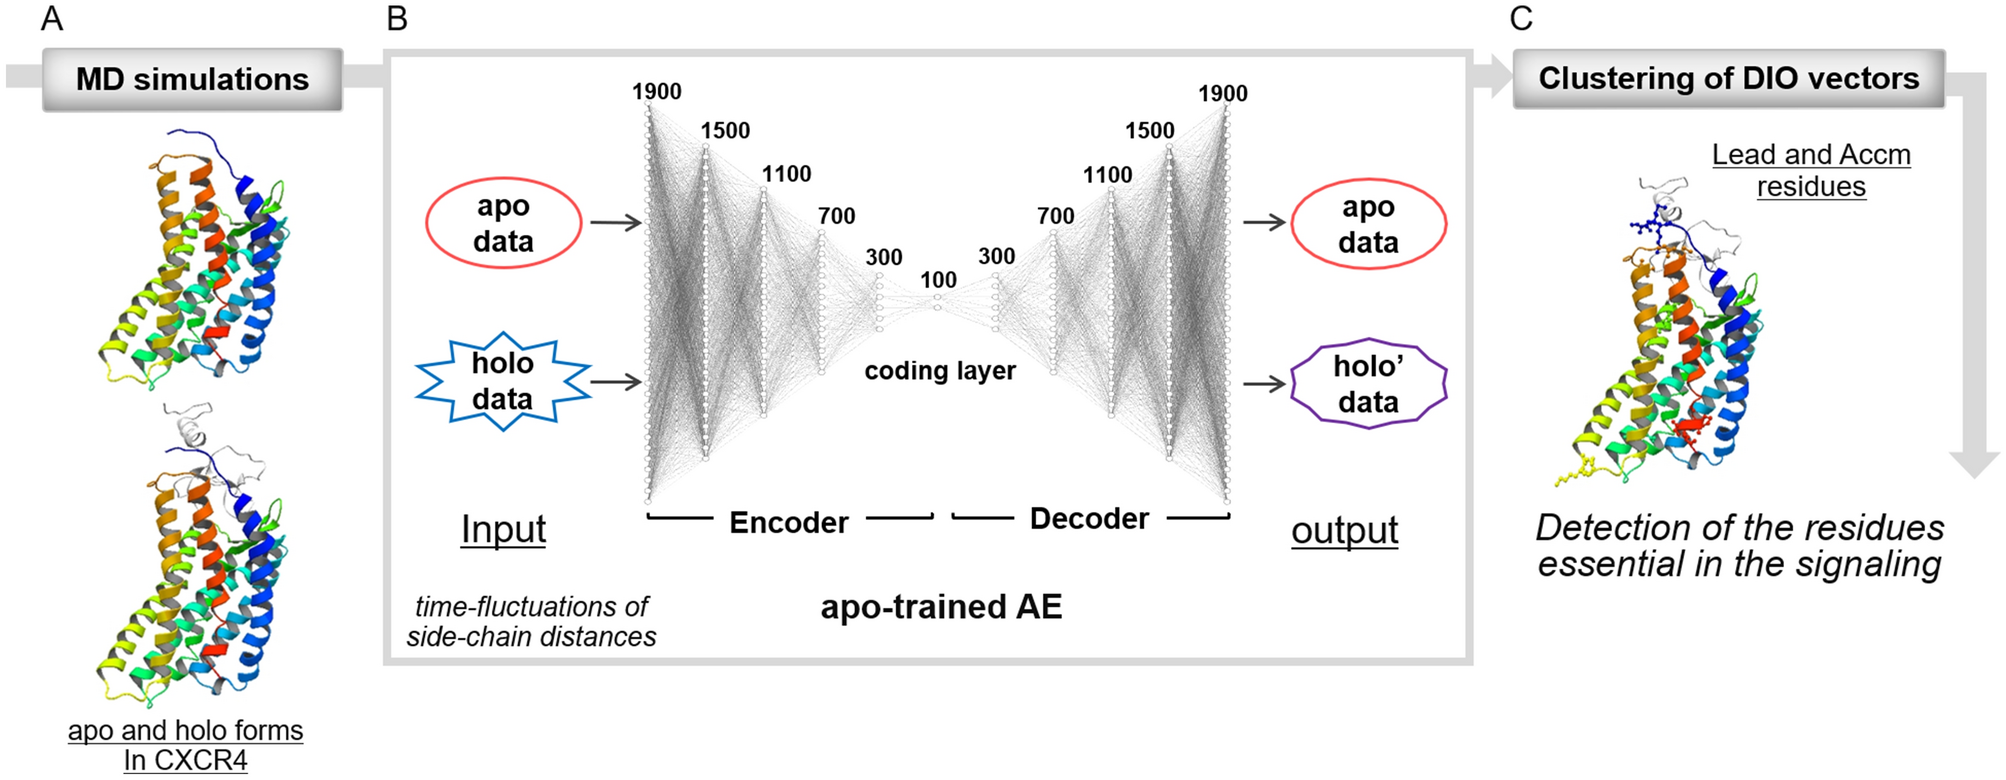

Tsuchiya, Y., Taneishi, K. & Yonezawa, Y. Autoencoder-based detection of the residues involved in G protein-coupled receptor signaling. Sci Rep 11, 19867 (2021). https://doi.org/10.1038/s41598-021-99019-z

#### **ARTICLE**

The described study involves the use of a multilayer AutoEncoder (AE) for feature extraction and pattern recognition in the context of protein dynamics. Here's a breakdown of the key points and processes described:

**Multilayer Pyramidal AutoEncoder Structure**

* AutoEncoder (AE): An unsupervised neural network used for dimensionality reduction, feature extraction, and pattern recognition.
* Architecture: The AE has 13 fully connected layers.
  * Encoder: 6 layers, with node counts increasing from 400 to 1900 in increments of 300 nodes.
  * Coding Layer: The central layer with 100 nodes.
  * Decoder: Mirrors the encoder with 6 layers.

* Function: The AE is trained to reconstruct the input data. It learns to minimize the mean squared error (MSE) between the original input and the reconstructed output.
* Feature Extraction: If the reconstruction error is minimized well, the AE effectively extracts features of the dynamics of residue pairs.

**Data Preparation**

* Input Data: The input to the AE is the vector of side-chain distances between residues.
* Distance Calculation: Distances are calculated between the centers of mass of the side-chain atoms (excluding hydrogen) for pairs of residues.
* Time Increments: Distances are measured from 50.5 ns to 1000 ns in 0.5 ns increments (1900 steps) within a trajectory from molecular dynamics (MD) simulations.
* Vector Representation: Each pair of residues is represented as a 1900-dimensional vector based on the distance data.

**Training the AutoEncoder**
* Data Split: The data is split into 80% for training and 20% for validation.
* Two Separate AEs: Two different AEs are trained, one with apo1 data and the other with apo2 data.
* Optimization: The Adam optimizer is used with a learning rate of 0.00001.
* Batch Size: The training data are divided into batches, each containing vectors for 100 residue pairs.
* Epochs: Training is conducted for 100,000 epochs and stops when the validation loss decreases.
* Hyperparameter Selection: The choice of hyperparameters (like learning rate, batch size) is based on achieving the best performance in terms of loss and accuracy.

Rate of Node Steps:

$$ \delta = \frac{{{input_{dim}} - {latent_{dim}}}}{{{n_{layers} + 1}}} $$


Loss Function:

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

where,
* $n$ is the number of samples.
* $y_i$ is the actual value for the ii-th sample.
* $\hat{y}_i$ is the predicted value for the ii-th sample



In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, nlayers, latent_dim):
        super().__init__()

        self.input_dim = input_dim
        self.nlayers = nlayers
        self.latent_dim = latent_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        delta = int((input_dim - latent_dim) / (nlayers + 1))

        # Encoder
        encoder = []
        nunits = input_dim
        for layer in range(nlayers):
            encoder.append(torch.nn.Linear(nunits, nunits - delta))
            encoder.append(torch.nn.ReLU())
            nunits = nunits - delta
        self.encoder = torch.nn.Sequential(*encoder)

        # Latent Space
        self.lv = torch.nn.Sequential(
            torch.nn.Linear(nunits, latent_dim),
            torch.nn.Sigmoid())

        # Decoder
        decoder = []
        nunits = latent_dim
        for layer in range(nlayers):
            decoder.append(torch.nn.Linear(nunits, nunits + delta))
            decoder.append(torch.nn.ReLU())
            nunits = nunits + delta
        self.decoder = torch.nn.Sequential(*decoder)

        # Output
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(nunits, input_dim),
            torch.nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        latent_space = self.lv(encoded)
        decoded = self.decoder(latent_space)
        output = self.output_layer(decoded)
        return latent_space, output


    def train_model(self, train_dataloader, valid_dataloader, optimizer, loss_function, epochs, save_model_path=None, checkpoint_interval=25):
        self.to(self.device)
        train_losses = []
        valid_losses = []

        start_time = time.time()

        print("Start Training:")
        for epoch in range(epochs):

            # Training step
            avg_train_loss = self.training_step(train_dataloader, optimizer, loss_function)
            train_losses.append(avg_train_loss)

            # Validation step
            avg_valid_loss, _, _ = self.evaluate_model(valid_dataloader, loss_function)
            valid_losses.append(avg_valid_loss)

            end_time = time.time()
            epoch_duration = end_time - start_time

            if (epoch) % 10 == 0 or epoch == epochs-1:
                print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.3f}, Valid Loss: {avg_valid_loss:.3f}, Duration: {epoch_duration:.2f}s')
                start_time = time.time()

            # Checkpointing
            if epoch % checkpoint_interval == 0 or epoch == epochs-1:
                if save_model_path != None:
                    checkpoint_path = os.path.join(save_model_path, f'checkpoint_epoch_{epoch}.pth')
                    torch.save(self.state_dict(), checkpoint_path)

        # Save model
        if save_model_path:
            torch.save(self.state_dict(), save_model_path)

        return train_losses, valid_losses

    def training_step(self, dataloader, optimizer, loss_function):
        self.train()
        losses = []
        for data in dataloader:
            data = data.to(self.device)
            _, output = self(data)
            loss = loss_function(output, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        avg_loss = np.mean(losses)

        return avg_loss

    def evaluate_model(self, dataloader, loss_function):
        self.eval()
        losses = []
        z = []
        x_hat = []
        with torch.no_grad():
            for data in dataloader:
                data = data.to(self.device)
                latent, output = self(data)
                loss = loss_function(output, data)
                losses.append(loss.item())

                z.append(latent.cpu().numpy())
                x_hat.append(output.cpu().numpy())

        avg_loss = np.mean(losses)
        z = np.concatenate(z, axis=0)
        z = np.reshape(z, (-1, self.latent_dim))
        x_hat = np.concatenate(x_hat, axis=0)
        x_hat = np.reshape(x_hat, (-1, self.input_dim))
        return avg_loss, z, x_hat

def data_normalization(data_array):
    # Find the maximum and minimum values along axis 0 (column-wise)
    maximums = np.max(data_array, axis=0)
    minimums = np.min(data_array, axis=0)
    # Normalize the data_array
    norm_array = (data_array - minimums) / (maximums - minimums)
    return norm_array, maximums, minimums

def data_denormalization(normalized_data, max_values, min_values):
    # Denormalize the data
    denorm_data = normalized_data * (max_values - min_values) + min_values
    return denorm_data


**Hyperparameters:**

* *partition* : Percentage selected of data as the training partition. Default = 0.8.

* *batch_size* :  Number of samples of the dataset per batch toload. It is the number of training examples utilized in one iteration. Default = 1.

* *latent_dim* : Number of dimensions of the latent space. It is a representation of compressed data in a low-dimensional space. Default = 2.

* *number_layers* : Number of layers in both encoder and decoder neural networks, excluding the layer of the latent space and the output layer. Default = 5.

* *learning_rate* : Learning rate used for the Adam optimizer. It is the parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of the loss function. Default = 0.0001

* *epochs* : Number of epochs required for training the model. It is the number times that the learning algorithm will work through the entire training dataset. Default = 100.

* *normalize* : Normalize the input data. Default = True.


In [ ]:
# Hyperparameters

traj_file = "/content/drive/MyDrive/PhD/AE/Examples/WT_apo_md_b25_CA_ChainsA_DRY_imagedFit_2000frames.npy"
test_traj_file = "/content/drive/MyDrive/PhD/AE/Examples/WT_holo_md_b25_CA_ChainsA_DRY_imagedFit_2000frames.npy"

dt = 1
partition = 0.8
batch_size = 1
latent_dim = 3
nlayers = 5
lr = 0.0001
epochs = 100

normalize = True
save_model_path = ""     # Path to save the model
load_model = None

**Data Setup/Featurization**

In [ ]:
# Load the Trajectories in numpy arrays
data = np.load(traj_file)[::dt]
test_data = np.load(test_traj_file)

# Filter Atoms (if necessari):
data = data[:, 0:50, :]
test_data = test_data[:, 0:50, :]

# Reshape Data
data = np.reshape(data, (len(data), data.shape[1]*data.shape[2]))
test_data = np.reshape(test_data, (len(test_data), test_data.shape[1]*test_data.shape[2]))

n_frames, n_features = np.shape(data)

# Normalize Data
if normalize:
    data, max_value, min_value = data_normalization(data)
    test_data, test_max_value, test_min_value = data_normalization(test_data)

# Select the data for training and validation steps
select_train = int(partition*data.shape[0])
select_valid = int((1-partition)*data.shape[0])
train = data[:select_train, :]
valid = data[-select_valid:, :]
test  = test_data[:,:]

# Create torch tensors from numpy arrays
train_data = torch.FloatTensor(train)
valid_data = torch.FloatTensor(valid)
test_data = torch.FloatTensor(test)

# Transform tensors into a pytorch dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                                                batch_size = batch_size,
                                                drop_last=True,
                                                shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(dataset = valid_data,
                                              batch_size = batch_size,
                                              drop_last=True,
                                              shuffle = False)
perf_dataloader = torch.utils.data.DataLoader(dataset = data,
                                              batch_size = batch_size,
                                              drop_last=False,
                                              shuffle = False)
test_dataloader = torch.utils.data.DataLoader(dataset = test_data,
                                              batch_size = batch_size,
                                              drop_last=False,
                                              shuffle = False)

**Model Instantiation / Optimizer and Loss definition**

In [ ]:
# Model Instantiation
model = AutoEncoder(input_dim = n_features, nlayers = nlayers-1, latent_dim = latent_dim)
model = model.to(model.device)

if load_model:
    model.load_state_dict(torch.load(load_model, map_location=torch.device('cpu')))
    print("Model Loaded: ", load_model)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Loss function
loss_function = torch.nn.MSELoss()

**Train Model**

In [ ]:
# Train Model

train_loss, val_loss = model.train_model(train_dataloader, valid_dataloader, optimizer, loss_function, epochs, save_model_path, checkpoint_interval=25)

Start Training:
Epoch 1/100 - Train Loss: 0.023, Valid Loss: 0.015, Duration: 8.39s
Epoch 11/100 - Train Loss: 0.010, Valid Loss: 0.011, Duration: 77.58s
Epoch 21/100 - Train Loss: 0.009, Valid Loss: 0.010, Duration: 76.63s
Epoch 31/100 - Train Loss: 0.008, Valid Loss: 0.009, Duration: 80.51s
Epoch 41/100 - Train Loss: 0.007, Valid Loss: 0.009, Duration: 84.83s
Epoch 51/100 - Train Loss: 0.007, Valid Loss: 0.009, Duration: 86.81s
Epoch 61/100 - Train Loss: 0.007, Valid Loss: 0.009, Duration: 87.88s
Epoch 71/100 - Train Loss: 0.006, Valid Loss: 0.009, Duration: 90.65s
Epoch 81/100 - Train Loss: 0.006, Valid Loss: 0.009, Duration: 89.05s
Epoch 91/100 - Train Loss: 0.006, Valid Loss: 0.009, Duration: 90.13s
Epoch 100/100 - Train Loss: 0.006, Valid Loss: 0.009, Duration: 81.75s


**Test Model**

In [ ]:
# Test Model
perf_loss, perf_z, perf_xhat = model.evaluate_model(perf_dataloader, loss_function)
print(f'Performance Loss: {perf_loss:.3f}')

Performance Loss: 0.007


**Denormalize Data**

In [ ]:
perf_data = data_denormalization(data, max_value, min_value)
perf_xhat = data_denormalization(perf_xhat, max_value, min_value)

**Plot Loss vs Epochs**

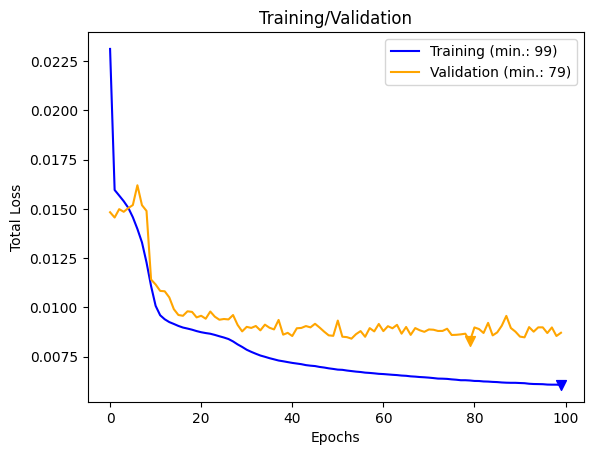

In [ ]:
#Training/Validation Plot: Loss vs Epoch

# Finding the minimum value points for train and validation losses
min_train_loss_value = min(train_loss)
min_val_loss_value = min(val_loss)
min_train_loss_idx = np.argmin(train_loss)
min_val_loss_idx = np.argmin(val_loss)

# Plot
plt.plot(range(len(train_loss)), train_loss, label=f"Training (min.: {min_train_loss_idx})", color='blue')
plt.plot(range(len(val_loss)), val_loss, label=f"Validation (min.: {min_val_loss_idx})", color='orange')

# Adding triangle markers at the minimum points
plt.scatter(min_train_loss_idx, train_loss[min_train_loss_idx], color='blue', marker='v', s=50)
plt.scatter(min_val_loss_idx, val_loss[min_val_loss_idx], color='orange', marker='v', s=50)

# Setting the rest of the plot elements
plt.legend()
plt.ylabel('Total Loss')
plt.xlabel('Epochs')
plt.title('Training/Validation')
plt.show()

### **ANALYZE AE PERFORMANCE**

**Trajectory Reconstruction**

In [ ]:
# RMSD

def calculate_rmsd(reference, trajectory):
    diff = reference - trajectory
    squared_diff = np.sum(diff ** 2, axis=2)
    mean_squared_diff = np.mean(squared_diff, axis=1)
    rmsd = np.sqrt(mean_squared_diff)
    return rmsd

def RMSD_plot(trajectory_data, output_data, moving_av="off"):
    # Create the reference trajectory
    reference = trajectory_data[0]

    # Compute RMSD for both datasets
    rmsd_trajectory = calculate_rmsd(reference, trajectory_data)
    rmsd_output = calculate_rmsd(reference, output_data)

    # Generate time array (assuming 0.5 ns per frame)
    time = np.arange(len(rmsd_trajectory))

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot RMSD over time for trajectory_data
    ax.plot(time, rmsd_trajectory, color='blue', linewidth=1, label='Original')

    # Plot RMSD over time for output_data
    ax.plot(time, rmsd_output, color='red', linewidth=1, label='Reconstruction')

    # Plot the moving average (optional)
    if moving_av == "on":
        window_size = 20  # Adjust window size as needed
        moving_avg_traj = np.convolve(rmsd_trajectory, np.ones(window_size)/window_size, mode='valid')
        moving_avg_out = np.convolve(rmsd_output, np.ones(window_size)/window_size, mode='valid')
        moving_avg_time = time[:len(moving_avg_traj)]
        ax.plot(moving_avg_time, moving_avg_traj, 'r', linewidth=0.5, label='Moving Average Trajectory')
        ax.plot(moving_avg_time, moving_avg_out, 'orange', linewidth=0.5, label='Moving Average Output')

    # Labels, title, and legend
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('RMSD (Å)')
    plt.title('RMSD Plot')
    plt.legend()

    # Show the plot
    plt.show()

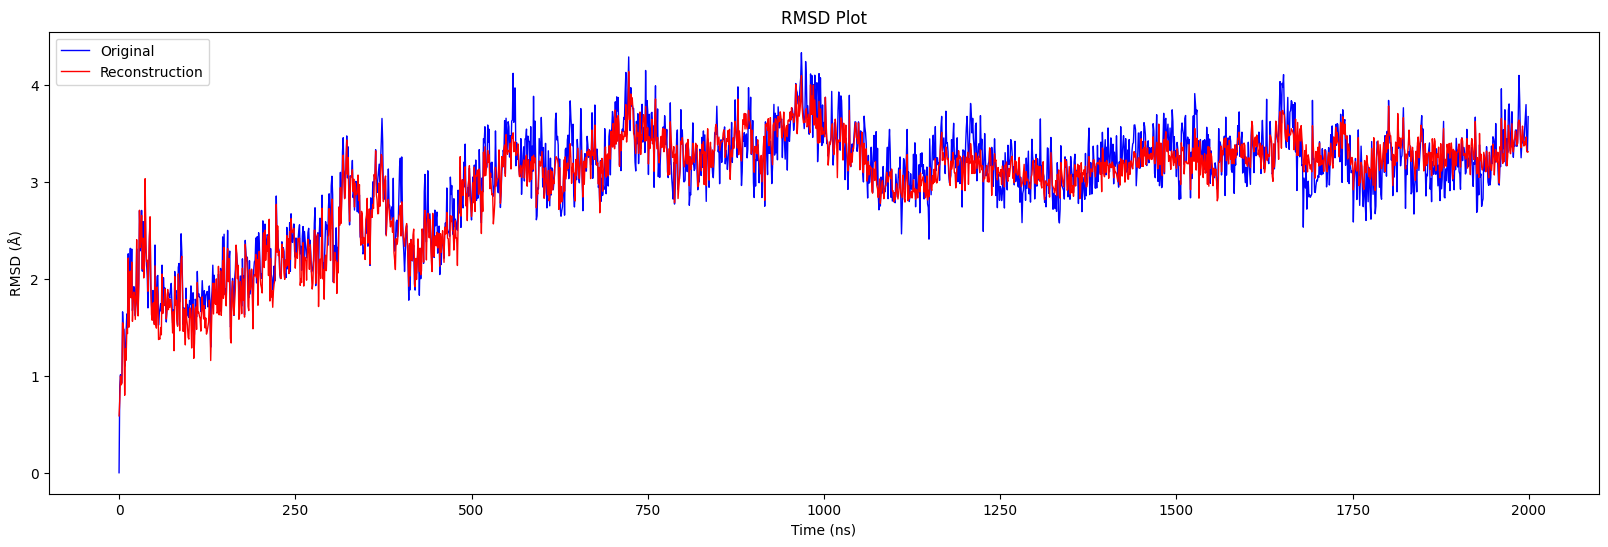

In [ ]:
perf_data = np.reshape(perf_data, (len(perf_data), -1, 3))
output = np.reshape(perf_xhat, (len(perf_xhat), -1, 3))
RMSD_plot(perf_data, output, moving_av="off")

#### **Latent Space Representation**

In [ ]:
# Latent Space Representation

def plot_latent_space(z):
    gs = gridspec.GridSpec(4, 4)
    fig = plt.figure(figsize=(15, 10))

    ax_main = plt.subplot(gs[1:4, :3])
    ax_xDist = plt.subplot(gs[0, :3], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:4, 3], sharey=ax_main)

    sc = ax_main.scatter(z[::1, 0], z[::1, 1], c=np.arange(len(z)), alpha=1, cmap='jet', s=2)

    # Position and size of colorbar based on ax_yDist
    pos = ax_yDist.get_position()
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Frames')

    # X-axis marginal distribution
    ax_xDist.hist(z[::1, 0], bins=100, color='blue', alpha=0.7)

    # Y-axis marginal distribution
    ax_yDist.hist(z[::1, 1], bins=100, color='blue', alpha=0.7, orientation='horizontal')

    ax_main.set_xlabel('z0', labelpad=20)
    ax_main.set_ylabel('z1', labelpad=20)

    plt.show()

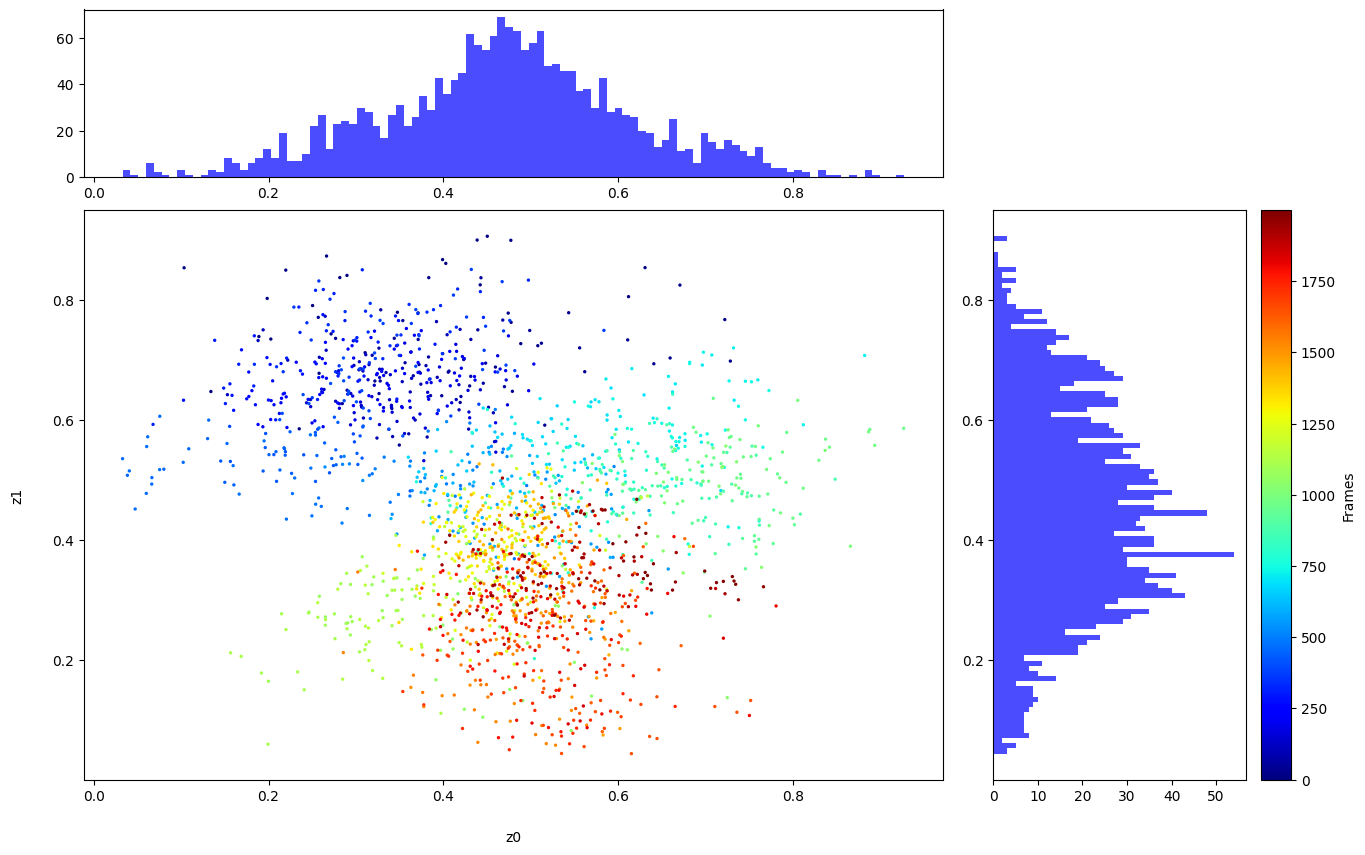

In [ ]:
plot_latent_space(perf_z)

### **WT vs VARIANT ANALYSIS: Residue Anomaly Detection**

**Test Model**

In [ ]:
# Test Model
test_loss, test_z, test_xhat = model.evaluate_model(test_dataloader, loss_function)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 0.022


**Denormalize Data**

In [ ]:
test_xhat = data_denormalization(test_xhat, test_max_value, test_min_value)

**RMSF**

In [ ]:
def calculate_rmsf(trajectory):
    # Calculate the mean position for each atom across all frames
    mean_positions = np.mean(trajectory, axis=0)

    # Calculate the squared deviations from the mean
    squared_deviations = (trajectory - mean_positions) ** 2

    # Sum the squared deviations for each coordinate, then average over frames and take the square root
    rmsf = np.sqrt(np.mean(np.sum(squared_deviations, axis=2), axis=0))
    return rmsf

def RMSF_plot(trajectory_data, output_data):
    # Calculate RMSF for both datasets
    rmsf_trajectory = calculate_rmsf(trajectory_data)
    rmsf_output = calculate_rmsf(output_data)

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 6))

    # Assuming the x-axis represents residue or atom indices
    indices = np.arange(len(rmsf_trajectory))

    # Plot RMSF for trajectory_data
    ax.plot(indices, rmsf_trajectory, color='blue', linewidth=1, label='Original')

    # Plot RMSF for output_data
    ax.plot(indices, rmsf_output, color='red', linewidth=1, label='Reconstruction')

    # Labels, title, and legend
    ax.set_xlabel('Residue or Atom Index')
    ax.set_ylabel('RMSF (Å)')
    plt.title('RMSF Plot')
    plt.legend()
    plt.show()

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot RMSF for DIO
    ax.plot(indices, (rmsf_trajectory - rmsf_output), color='orange', linewidth=1, label='DIO')

    # Labels, title, and legend
    ax.set_xlabel('Residue or Atom Index')
    ax.set_ylabel('RMSF (Å)')
    plt.title('RMSF Plot')
    plt.legend()
    plt.show()

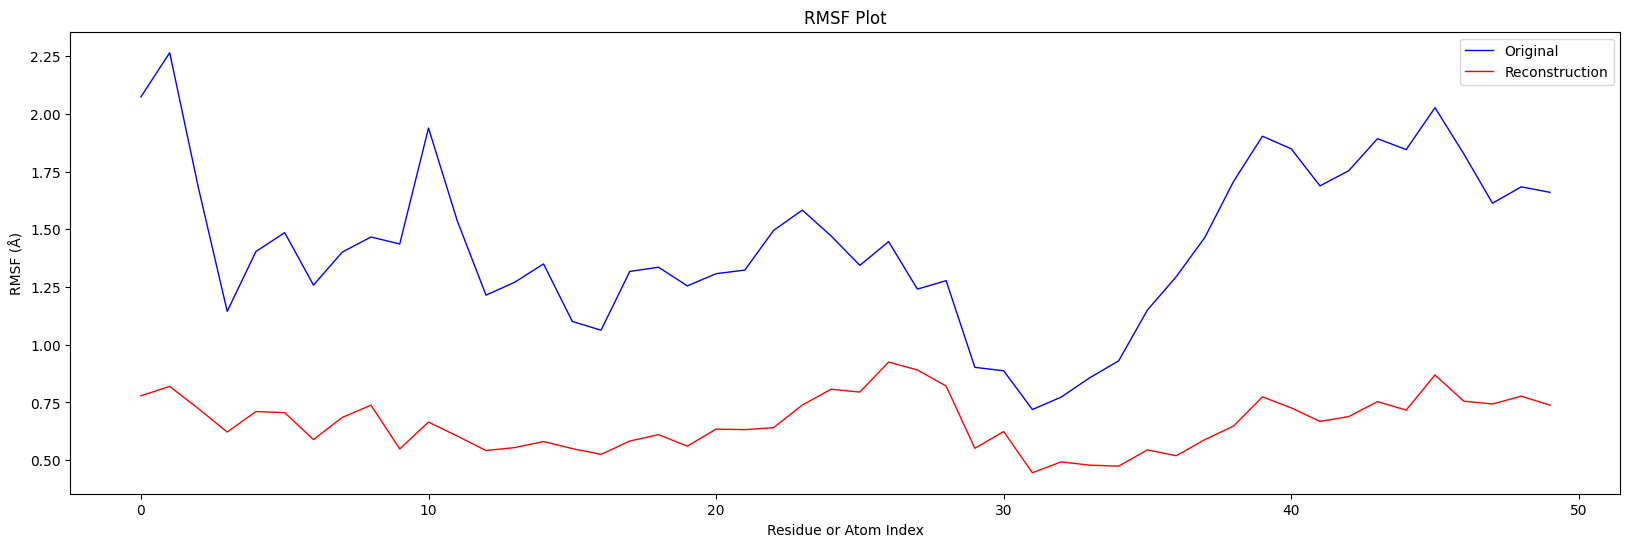

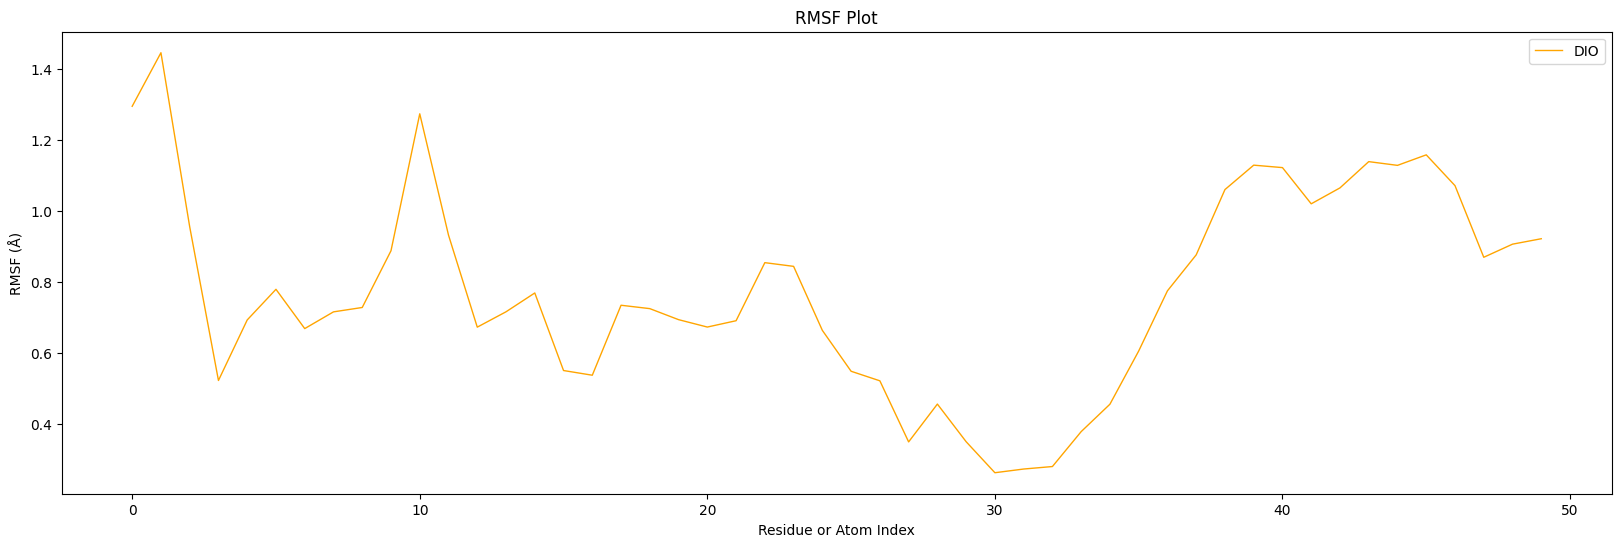

In [ ]:
test_data = np.reshape(test_data, (len(test_data), -1, 3))
output = np.reshape(test_xhat, (len(test_xhat), -1, 3))
RMSF_plot(perf_data, output)